# High-Resolution Time Delay Estimation Between Noisy Signals

## Time-Domain Techniques

### Cross-Correlation and Parabolic Peak Interpolation

#### Problem statement

The cross-correlation between two signals $x(t)$ and $y(t)$ (with $y$ being a delayed version of $x$ plus noise)

which, in discrete form, becomes a sum over time shifts. The delay that maximizes $R_{xy}(\tau)$ is the estimated time difference of arrival. In practice, one computes the discrete cross-correlation (using xcorr or FFT methods) and finds the index $k_0$ of the peak. This $k_0$ gives the nearest integer-sample delay. To achieve fractional delay estimates, we can interpolate around this peak.

In [ ]:
# x, y: input signals (1D arrays), assume len(y) ≈ len(x)
import numpy as np
import matplotlib.pyplot as plt
from utils.rPPG_methods import CHROM_win

pkl_path = "data/example/highspeed_roi/sid101-rid1-qhy5iii174c-seg1-roi.pkl"
def load_xy_from_pkl(pkl_path, hs_fps=150):
    roi_df = np.load(pkl_path, allow_pickle=True)
    x = roi_df['roi-forehead'].to_list()
    y = roi_df['roi-right_cheek'].to_list()
    x = np.array(x)
    y = np.array(y)

    x = x[:,[2,1,0]] # BGR -> RGB
    y = y[:,[2,1,0]]

    x = CHROM_win(x[:,None,:], FS=hs_fps)
    y = CHROM_win(y[:,None,:], FS=hs_fps)
    x = x[0]
    y = y[0]
    return x, y
x, y = load_xy_from_pkl(pkl_path)
hs_fps = 150


#### Parabolic Peak Interpolation

A common approach is parabolic interpolation using the correlation values at the peak and its immediate neighbors. Assuming $R_{xy}(k_0)$ is the maximum at integer lag $k_0$, with neighbors $R_{xy}(k_0-1)$ and $R_{xy}(k_0+1)$, we fit a quadratic through these three points and find its vertex. If we denote $y(-1)=R_{xy}(k_0-1)$, $y(0)=R_{xy}(k_0)$, $y(1)=R_{xy}(k_0+1)$, the fractional offset $\delta$ from $k_0$ that maximizes the parabola is

In [ ]:
def frac_delay(x, y):
    # Compute cross-correlation (full mode to get negative and positive lags)
    corr = np.correlate(x, y, mode='full')  
    lags = np.arange(-len(y)+1, len(x))    # corresponding lag values

    # Find index of max correlation
    k0 = np.argmax(corr)
    peak_lag = lags[k0]        # integer lag of max correlation

    # Parabolic interpolation around the peak
    if 0 < k0 < len(corr)-1:
        y_m1, y_0, y_p1 = corr[k0-1], corr[k0], corr[k0+1]
        denom = (y_m1 - 2*y_0 + y_p1)
        if denom != 0:
            delta = (y_m1 - y_p1) / (2 * denom)
        else:
            delta = 0.0
    else:
        delta = 0.0
    frac_delay = peak_lag + delta   # estimated fractional delay (in samples)
    return frac_delay
frac_delay = frac_delay(x, y)
print(f"Fractional delay: {frac_delay*1000/hs_fps:.3f}ms")

### Sinc Interpolation and Upsampling

Rather than fitting a simple parabola, one can more precisely model the continuous cross-correlation function using band-limited interpolation. If the signals are band-limited (which is often the case if they were sampled at Nyquist rate), the cross-correlation will be a band-limited function. Sinc interpolation (reconstructing the correlation with an ideal low-pass filter) can yield an accurate fractional-delay estimate with minimal bias. In practice, ideal sinc reconstruction is not feasible, but one can **upsample** the signals or the correlation via zero-padding in frequency domain to approximate it.

- **Time-domain upsampling**: Increase the sampling rate (e.g., by polyphase filtering or inserting zeros and lowpass filtering) for one or both signals and then compute cross-correlation at the higher rate. With a high enough upsampling factor, the delay can be determined to the desired fraction of a sample. This is computationally more expensive (since signals length and correlation computations increase by the upsampling factor).
- **Frequency-domain zero-padding**: A clever trick is to compute the cross-correlation via FFT with zero-padding to achieve interpolation. For example, take FFTs of $x$ and $y$ (of length $N$), zero-pad them to length $M \gg N$, then compute the cross-correlation via inverse FFT of $X(f)Y^*(f)$. The resulting cross-correlation is effectively sampled at a finer time grid (because zero-padding in frequency corresponds to interpolation in time). This yields a dense correlation curve from which a more precise peak can be found. Note: This is equivalent to sinc interpolation of the correlation function.
- **Gaussian or Cosine interpolation**:

In [ ]:
def sinc_interp(x, y, scale_factor:int=10):
    N = len(x)
    M = scale_factor * N  # e.g., 16x upsampling in time
    X = np.fft.rfft(x, n=N)
    Y = np.fft.rfft(y, n=N)
    # Cross-spectrum and normalized inverse FFT
    cross_spec = X * np.conj(Y)

    # zero-pad them to M in frequency domain
    cross_spec = np.pad(cross_spec, (0, M//2-N//2), constant_values=(0,))
    corr = np.fft.irfft(cross_spec, n=M)  # length M correlation, contains correlation at finer steps
    # Because signals are of length N, valid correlation lags are within +/- (N-1)
    # corr array is circular; we should shift it to center = zero lag
    corr = np.roll(corr, M//2)  
    valid_lags = np.arange(-N+1, N)
    corr_valid = corr[M//2 - (N-1) : M//2 + (N-1) + 1]
    k0 = np.argmax(corr_valid)
    peak_lag_frac = valid_lags[0] + k0

    return peak_lag_frac/scale_factor

sinc_interp_factor = 10
peak_lag_frac = sinc_interp(x, y, scale_factor=sinc_interp_factor)
print(f"Sinc interpolation delay: {peak_lag_frac*1000/hs_fps:.3f}ms")


## Frequency-Domain Techniques
Frequency-domain methods exploit the fact that a time delay corresponds to a linear phase shift across frequency components. If $y(t)$ is a delayed version of $x(t)$ by $\tau$, and ignoring noise for the moment, their continuous Fourier transforms are related by $Y(f) = X(f),e^{-j 2\pi f \tau}$. This means the cross-power spectrum $S_{xy}(f) = X(f) , Y^*(f)$ contains a phase term $e^{-j2\pi f \tau}$ proportional to the delay. By analyzing the phase of the cross-spectrum (or the transfer function between $x$ and $y$), one can estimate $\tau$ with fine resolution.

### Phase Difference (Cross-Spectrum) Method (NOT WORKING WELL!)

In practice, given discrete signals, one can compute the cross-spectrum via the FFT. Let $X[k]$ and $Y[k]$ be the DFTs of $x$ and $y$. The cross-spectrum is $C[k] = X[k]\,Y^*[k]$. If $y$ is a shifted version of $x$, we expect:

$$C[k] \approx A(k)\,e^{-j\omega_k \tau},$$

where $\omega_k = 2\pi k / N$ is the digital frequency and $A(k)$ is some complex amplitude (including any gain differences). The phase of $C[k]$ is $\angle C[k] \approx -\omega_k \tau$ (mod $2\pi$). If the delay $\tau$ is small, this phase is nearly linear in $k$. We can unwrap the phase across the spectrum and perform a linear regression: the slope of $\angle C(\omega)$ vs. $\omega$ gives $-\tau$. In other words,
	•	Compute $\phi[k] = \text{unwrap}(\angle C[k])$ for $k=0…N-1$.
	•	Fit a line $\phi[k] \approx -\omega_k \tau + b$ (where $b$ is some constant phase offset). The best-fit slope in a least-squares sense yields $\hat{\tau}$.

Another equivalent view: the time delay can be estimated by the group delay between the signals, defined as $-\frac{d}{d\omega}\angle C(\omega)$. For a pure delay, this is constant and equal to the delay. In discrete form, one can compute group delay by finite difference of phase or by special algorithms.

A simple example: if $x[n]$ and $y[n]$ are sinusoids of frequency $f_0$ with a phase difference, the delay can be obtained from that phase difference divided by $2\pi f_0$. For broadband signals, the phase method uses all frequencies to improve accuracy (basically a larger aperture for estimation).

**Why it fails:**
- Phase unwrapping and ambiguity: One must unwrap the phase correctly. If the delay is large such that phase changes by more than $2\pi$ over the band, naive unwrapping might jump by $2\pi$ at wrong places. However, this is usually manageable by standard unwrapping algorithms if SNR is reasonably high.
- Requires coherent spectrum: If the two signals differ not just by delay but also by other filtering (e.g., different frequency responses or multipath effects), the phase won’t be a perfect line. That can bias the estimate unless one restricts to frequency regions where the phase is linear. In other words, this assumes the two signals are related by a pure delay (and maybe gain); any deviation (like distortion) reduces accuracy.
- Sensitive to low SNR at certain frequencies: A frequency bin with little signal (and mostly noise) will have a random phase, which can throw off the linear fit. Typically one must weight or discard frequencies with low coherence. Using a cross-spectrum coherence threshold or weighting by $|C[k]|$ can mitigate this.
- Implementation complexity is moderate: fitting a line to phase data is straightforward, but one must handle edge cases (phase wrap, outliers) carefully. It’s more complex than a simple time-domain peak search.


In [ ]:
import numpy as np

fs = hs_fps
N = len(x)
X = np.fft.rfft(x)
Y = np.fft.rfft(y)
# Assume we have cross-spectrum from earlier FFTs: cross_spec = X * np.conj(Y)
cross_spec = X * np.conj(Y)  # from previous example or computed elsewhere
freqs = np.fft.rfftfreq(N, d=1.0/fs)  # frequency axis (Fs = sampling rate)
phase = np.angle(cross_spec)
phase_unwrapped = np.unwrap(phase)

# Optionally select frequency range of interest:
# e.g., use only frequencies where |cross_spec| is significant 
mask = np.abs(cross_spec) > np.max(np.abs(cross_spec)) * 0.1  # example threshold
freqs_used = freqs[mask]
phase_used = phase_unwrapped[mask]

plt.subplot(2,1,1)
plt.plot(freqs, np.abs(cross_spec))
plt.xlim([0, 4])

plt.subplot(2,1,2)
plt.plot(freqs, phase, label='Phase')
plt.plot(freqs, phase_unwrapped, label='Unwrapped Phase')

# Plot red dotted lines for each frequency in freqs_used
for i, f_used in enumerate(freqs_used):
    if i == 0: # Add label only for the first line to avoid cluttering the legend
        plt.axvline(x=f_used, color='red', linestyle='dotted', label='Freqs Used')
    else:
        plt.axvline(x=f_used, color='red', linestyle='dotted')
plt.xlabel('Frequency (Hz)')
plt.xlim([0,4])
plt.ylim([-2*np.pi, 2*np.pi])
plt.legend()

if len(freqs_used) > 0:
    # Fit a line to phase_used vs freqs_used
    coeffs = np.polyfit(freqs_used, phase_used, 1)  # returns [slope, intercept]
    slope = coeffs[0]
    tau_est = -slope / (2*np.pi)
else:
    # If no frequencies are used, estimate tau from the first frequency and pha
    tau_est = phase_used[0]/(2*np.pi*freqs_used[0])

print(f"Frequency bins: {freqs_used}Hz, \nPhase: {phase_used}, \nEstimated time delay: {tau_est*1000:.3f}ms")

### Generalized Cross-Correlation and Phase Transform (GCC-PHAT)

The Generalized Cross-Correlation (GCC) framework is a family of techniques that modify the cross-correlation by applying a frequency-domain weighting to emphasize certain signal characteristics. The standard cross-correlation is actually one member of this family (with a flat frequency weight). By choosing a clever weight, one can improve the detection of the correlation peak in noisy or reverberant conditions.

One popular choice is the Phase Transform (PHAT) weighting. In GCC-PHAT, we whiten the spectrum by dividing by the magnitude of the cross-spectrum. The PHAT-weighted cross-correlation is computed as:

$$
R_{\text{PHAT}}(\tau) = \frac{1}{2\pi}\int_{-\pi}^{\pi} \frac{X(\omega)Y^*(\omega)}{|X(\omega)Y^*(\omega)|} \, e^{j\omega\tau}\,d\omega\,.
$$

Intuitively, we keep only the phase of each frequency’s contribution (hence “Phase Transform”) and ignore the magnitude. This has the effect of giving equal weight to all frequencies, so that no single frequency (or narrow band) dominates the correlation. If $y(t)$ is exactly $x(t-\tau_0)$ (delayed copy), and there is no other distortion, then $X(\omega)Y^*(\omega) = |X(\omega)|^2 e^{-j\omega\tau_0}$. Plugging into the PHAT formula yields:

$$
R_{\text{PHAT}}(\tau) = \frac{1}{2\pi}\int_{-\pi}^{\pi} e^{-j\omega\tau_0} e^{j\omega\tau}\,d\omega = \delta(\tau - \tau_0)\,,
$$

an ideal delta-function peak at the true delay. In discrete time, we can’t get an infinite resolution delta, but we do get a very sharp peak concentrated at the correct sample (and possibly fractional lag after interpolation).

In [ ]:
import numpy as np

# Compute FFT of signals (zero-pad to length N for efficient convolution length)
N = len(x) + len(y) - 1
X = np.fft.rfft(x, n=N)
Y = np.fft.rfft(y, n=N)
freqs = np.fft.rfftfreq(N, d=1/hs_fps)
C = X * np.conj(Y)
# Apply PHAT weighting
EPS = 1e-6
# C_phat = C   # add small EPS to avoid /0
C_phat = C / (np.abs(C) + EPS)   # add small EPS to avoid /0
gcc_phat = np.fft.irfft(C_phat, n=N)
gcc_phat = np.roll(gcc_phat, N//2)  # shift zero lag to center
# Now gcc_phat is the cross-correlation (PHAT weighted)
lag_index = np.argmax(gcc_phat)
tau_samples = lag_index - (len(x)-1)  # convert index to lag (center corresponds to 0 lag)

In [ ]:
def gcc_0(x, y, fs, tau_, PHAT_weight = False):
    # N = len(x) + len(y) - 1
    N = len(x)
    fs = hs_fps
    X = np.fft.rfft(x, n=N)
    Y = np.fft.rfft(y, n=N)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    C = X * np.conj(Y)*np.exp(1j*2*np.pi*freqs*tau_)
    
    # Apply PHAT weighting
    if PHAT_weight:
        EPS = 1e-6
        C_phat = C / (np.abs(C) + EPS)   # add small EPS to avoid /0
    else:
        C_phat = C   # add small EPS to avoid /0
    gcc_phat = np.fft.irfft(C_phat, n=N)
    # gcc_phat = np.roll(gcc_phat, N//2)  # shift zero lag to center
    # Now gcc_phat is the cross-correlation (PHAT weighted)
    # return np.max(gcc_phat)
    return gcc_phat[0]

In [ ]:
tau_list = np.linspace(-.1, 0.1, 1000)
gcc_tau = list()
for tau_ in tau_list:
    gcc_tau.append(gcc_0(x, y, hs_fps, tau_, True))
print(f"Estimated tau: {tau_list[np.argmax(gcc_tau)]*1000:.3f}ms")

In [ ]:
tau_list = np.linspace(-.1, 0.1, 1000)
gcc_tau = list()
for tau_ in tau_list:
    gcc_tau.append(gcc_0(x, y, hs_fps, tau_))
print(f"Estimated tau: {tau_list[np.argmax(gcc_tau)]*1000:.3f}ms")

### Subspace Methods (MUSIC and ESPRIT)
Subspace methods like MUSIC (Multiple Signal Classification) and ESPRIT were originally developed for direction-of-arrival estimation on sensor arrays, but they can be adapted for time-delay estimation to achieve even higher resolution than classical methods​. The idea is to model the signals and noise and then use eigen-decomposition to separate the “signal subspace” (which contains the delayed copies of the waveform) from the “noise subspace.” These methods are especially powerful when multiple propagation paths (multiple delays) exist, as they can resolve distinct delays that are closer than a sample period (super-resolution). How it works (conceptually for a single delay): If $y(t)$ is a delayed version of $x(t)$, in the frequency domain we have $Y(f) = X(f)e^{-j2\pi f \tau}$. We can treat each frequency component as a sensor observing the phase-shifted signal. For example, take a set of $M$ frequency bins ${f_1, f_2, ..., f_M}$ where the signal has significant energy. The phase of $Y$ relative to $X$ at those bins is $-2\pi f_k \tau$. This forms a model akin to an array of $M$ sensors (frequencies) with a single source at “angle” (delay) $\tau$. MUSIC can be applied by constructing a covariance matrix of the cross-spectral data across these $M$ “sensors.” The covariance will have a rank-1 signal subspace (for one delay) plus noise. MUSIC then scans a candidate $\tau$ and evaluates a pseudo-spectrum $P(\tau) = \frac{1}{\mathbf{a}^H(\tau) \mathbf{N} \mathbf{N}^H \mathbf{a}(\tau)}$ where $\mathbf{N}$ is the noise subspace eigenvectors and $\mathbf{a}(\tau)$ is the array steering vector $[1, e^{-j2\pi f_2 \tau}, ..., e^{-j2\pi f_M \tau}]^T$. Peaks of $P(\tau)$ indicate likely delays (where the candidate steering vector aligns with the signal subspace)​. ESPRIT, on the other hand, can find the delays algebraically by exploiting invariances (often requiring paired sensors or frequencies). In the time domain, one can also create multiple “sensors” by taking delayed versions of the signal (e.g., constructing a covariance matrix from $[x(t), y(t)]$ as two sensors, or using lagged versions as additional sensors via covariance lags or sub-band averaging​). In ultrawideband scenarios or radar with multiple echoes, one can often partition the spectrum or time into sub-bands which act as multiple measurements for the subspace algorithm​. These details can get mathematically heavy, but the end result is an estimate of one or more delays with very high precision.

In [ ]:
N = len(x)
X = np.fft.rfft(x,N)
Y = np.fft.rfft(y,N)
freqs = np.fft.rfftfreq(N, 1/hs_fps)

In [ ]:
Z = X*Y.conj()
R = np.outer(Z, Z.conj())
eigvals, eigvecs = np.linalg.eigh(R)

In [ ]:
En = eigvecs[:, :-1]
delay_grid = np.linspace(-.1, .1, 500)
# delay_grid = np.linspace(-0.1, 0.1, 100)
pseudospectrum = []
for tau_ in delay_grid:
    a = np.exp(-1j * 2 * np.pi * tau_ * freqs)
    a = a[:, np.newaxis]
    denom = np.abs(a.conj().T @ En @ En.conj().T @ a)[0,0]
    pseudospectrum.append(1/denom)


In [ ]:
print(delay_grid[np.argmax(pseudospectrum)])
plt.plot(delay_grid, np.array(pseudospectrum))

In [ ]:
a = np.exp(-1j * 2 * np.pi * tau_ * freqs)
a_abs = a*np.abs(Z)

In [ ]:
En = eigvecs[:, -1:]
# delay_grid = np.linspace(-1, 1, 100)
delay_grid = np.linspace(-0.1, 0.1, 100)
pseudospectrum = []
for tau_ in delay_grid:
    a = np.exp(-1j * 2 * np.pi * tau_ * freqs)
    a = a[:, np.newaxis]
    denom = np.abs(a.conj().T @ En @ En.conj().T @ a)[0,0]
    pseudospectrum.append(denom)

print(delay_grid[np.argmax(pseudospectrum)])
plt.plot(delay_grid, np.array(pseudospectrum))

pseudospectrum = []
for tau_ in delay_grid:
    a = np.exp(-1j * 2 * np.pi * tau_ * freqs)*np.abs(Z)
    a = a[:, np.newaxis]
    denom = np.abs(a.conj().T @ En @ En.conj().T @ a)[0,0]
    pseudospectrum.append(denom)

print(delay_grid[np.argmax(pseudospectrum)])
plt.plot(delay_grid, np.array(pseudospectrum))

#### Sub-band MUSIC

In [ ]:
# MUSIC applied on selected frequency bins
def music_on_selected_band(x, y, fs, freq_band, delay_grid):
    N = len(x)
    X = np.fft.rfft(x)
    Y = np.fft.rfft(y)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    # Select frequency bins
    bin_mask = (freqs >= freq_band[0]) & (freqs <= freq_band[1])
    X_sel = X[bin_mask]
    Y_sel = Y[bin_mask]
    freqs_sel = freqs[bin_mask]
    # Cross-spectrum
    Z = X_sel * np.conj(Y_sel)
    R = np.outer(Z, Z.conj())
    # Eigen-decomposition
    eigvals, eigvecs = np.linalg.eigh(R)
    En = eigvecs[:, :-1]  # assume 1 delay
    # MUSIC pseudospectrum
    pseudospectrum = []
    for tau in delay_grid:
        a = np.exp(-1j * 2 * np.pi * freqs_sel * tau)[:, np.newaxis]
        denom = np.abs(a.conj().T @ En @ En.conj().T @ a)[0, 0]
        pseudospectrum.append(1 / denom)
    return np.real(pseudospectrum)

In [ ]:
delay_grid = np.linspace(-.1, .1, 500)
freq_band = [0.7, 2.0]
# freq_band = [1.4, 1.5]
fs = hs_fps
pseudo_spectrum_narrow_band = music_on_selected_band(x, y, fs, freq_band, delay_grid)
print(delay_grid[np.argmax(pseudo_spectrum_narrow_band)])
plt.plot(delay_grid, pseudo_spectrum_narrow_band)

# Benchmark on Thai HS dataset

## Time Delay Estimation

In [ ]:
import importlib

# Import the module
time_delay_estimation = importlib.import_('time_delay_estimation')

# Reload the module to ensure any changes are applied
time_delay_estimation = importlib.reload(time_delay_estimation)

# Define the list of function names
delay_estimation_methods = ['frac_delay', 'sinc_interp', 'gcc_delay']

# Create a dictionary of functions using dictionary comprehension
delay_estimation_functions = {
    method: getattr(time_delay_estimation, method) 
    for method in delay_estimation_methods
}

# Setting parameters for the delay estimation
tau_grid = np.linspace(0,.1, 1000)
scale_factor = 16
PHAT_weight = False

fs = 150

In [ ]:
def load_xy_from_pkl(pkl_path, hs_fps=150):
    roi_df = np.load(pkl_path, allow_pickle=True)
    x = roi_df['roi-forehead'].to_list()
    y = roi_df['roi-right_cheek'].to_list()
    ts = roi_df['timestamp'].to_list()

    x = np.array(x)
    y = np.array(y)
    ts = np.array(ts)
    ts-=ts[0]

    x = x[:,[2,1,0]] # BGR -> RGB
    y = y[:,[2,1,0]]

    x = CHROM_win(x[:,None,:], FS=hs_fps)
    y = CHROM_win(y[:,None,:], FS=hs_fps)
    x = x[0]
    y = y[0]
    return (x, y), ts[:len(x)]

def load_roi_from_pkl(pkl_path, hs_fps=150):
    roi_df = np.load(pkl_path, allow_pickle=True)
    roi_list = ['forehead', 'glabella', 'left_cheek', 'right_cheek', 'chin']
    roi_dict = {}
    for roi_ in roi_list:
        roi_arr = np.array(roi_df['roi-forehead'].to_list())
        roi_arr = roi_arr[:,[2,1,0]] # BGR -> RGB
        roi_arr = CHROM_win(roi_arr[:,None,:], FS=hs_fps)[0]
        roi_dict[roi_] = roi_arr
    return roi_dict

In [ ]:
import re
import os
import pandas as pd
from glob import glob
from collections import defaultdict
from module_ptt_estimator.extractor import PTTExtractor

roi_path = r"C:\Users\Shootall\Documents\rPPG-dataset\highspeed_roi"
bp_path = r"C:\Users\Shootall\Documents\rPPG-dataset\highspeed_bp\highspeed_bp"
roi_file_list = glob(os.path.join(roi_path, "*.pkl"))
bp_file_list = glob(os.path.join(bp_path, "*.pkl"))

pttExt = PTTExtractor()

delay_df = defaultdict(list)

for f_ in roi_file_list:
    (x, y), ts = load_xy_from_pkl(f_, hs_fps=fs)
    # x = x/np.abs(hilbert(x))
    # y = y/np.abs(hilbert(y))
    match_name = re.search('sid(\d+)-rid(\d+)-qhy5iii174c-seg(\d+)-roi.pkl', f_).groups()
    sid, rid, i_seg = match_name
    print(f"Working on {match_name}")

    delay_df['sid'].append(sid)
    delay_df['rid'].append(rid)
    delay_df['i_seg'].append(i_seg)

    bp_df = np.load(os.path.join(bp_path, f"sid{sid}-rid{rid}-uscom_bp_plus-seg{i_seg}-reference.pkl"), allow_pickle=True)
    if bp_df.shape[0] > 0:
        delay_df['sbp'].append(bp_df.iloc[0]['Log_Sys'])
        delay_df['dbp'].append(bp_df.iloc[0]['Log_Dia'])
    else:
        delay_df['sbp'].append(np.nan)
        delay_df['dbp'].append(np.nan)

    for de_method in delay_estimation_methods:
        delay, max_corr = delay_estimation_functions[de_method](x, y, fs, scale_factor=scale_factor, tau_grid=tau_grid, PHAT_weight=PHAT_weight)
        # print(f"{de_method}: {delay:.4f} seconds")
        delay_df[de_method].append(delay)
        delay_df[f"{de_method}_max_corr"].append(max_corr)
    pai_ptt_peak = pttExt.ptt_via_peak2peak(ts, y, ts, x,)
    delay_df['pai_ptt_peak'].append(np.mean(pai_ptt_peak['valid_ptt_list']))
    pai_ptt_slope = pttExt.ptt_via_slope2slope(ts, y, ts, x)
    delay_df['pai_ptt_slope'].append(np.mean(pai_ptt_slope['valid_ptt_list']))
    pai_ptt_corr = pttExt.ptt_via_correlation(ts, y, ts, x)
    delay_df['pai_ptt_corr'].append(pai_ptt_corr)

delay_df = pd.DataFrame(delay_df)

In [ ]:
import matplotlib.pyplot as plt

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot histogram for gcc_delay
ax1.hist(delay_df['gcc_delay']*1000, bins=30, alpha=0.7)
ax1.set_xlabel('GCC Delay (ms)')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of GCC Delay')

# Plot histogram for pai_ptt_peak
ax2.hist(delay_df['pai_ptt_peak']*1000, bins=30, alpha=0.7)
ax2.set_xlabel('PAI PTT Peak (ms)')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of PAI PTT Peak')

plt.tight_layout()
plt.show()

# Print basic statistics
print("GCC Delay Statistics (ms):")
print(delay_df['gcc_delay'].describe()*1000)
print("\nPAI PTT Peak Statistics (ms):")
print(delay_df['pai_ptt_peak'].describe()*1000)

In [ ]:
# (x, y), ts = load_xy_from_pkl(f_, hs_fps=fs)
# pai_ptt_peak = pttExt.ptt_via_peak2peak(ts, y, ts, x, plot=True)
# pai_ptt_slope = pttExt.ptt_via_slope2slope(ts, y, ts, x, plot=True)
# pai_ptt_corr = pttExt.ptt_via_correlation(ts, y, ts, x, plot=True)

# from scipy.signal import hilbert
# xh = x/np.abs(hilbert(x))
# yh = y/np.abs(hilbert(y))
# # compare x and xh
# plt.subplot(2,1,1)
# plt.plot(x)
# plt.plot(y)

# plt.subplot(2,1,2)
# plt.plot(xh)
# plt.plot(yh)

In [139]:
delay_df

,sid,rid,i_seg,sbp,dbp,frac_delay,frac_delay_max_corr,sinc_interp,sinc_interp_max_corr,gcc_delay,gcc_delay_max_corr,pai_ptt_peak,pai_ptt_slope,pai_ptt_corr
0,100,1,1,148.0,93.0,0.013950,0.006670,0.013750,0.000417,0.013914,0.006670,0.063299,0.048243,0.023660
1,100,1,2,148.0,93.0,0.009128,0.007978,0.009167,0.000499,0.009109,0.007980,0.051968,0.033800,0.016900
2,100,1,3,148.0,93.0,0.013224,0.009042,0.013333,0.000565,0.013213,0.009042,0.047643,0.047027,0.023660
3,100,1,4,148.0,93.0,0.017688,0.006717,0.017500,0.000420,0.017718,0.006718,0.066249,0.037714,0.030420
4,100,1,5,148.0,93.0,0.021274,0.004774,0.021250,0.000298,0.021321,0.004774,0.074812,0.055771,0.030420
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1362,99,3,1,126.0,87.0,0.001326,0.005029,0.001250,0.000314,0.001301,0.005029,0.078045,0.054078,0.010140
1363,99,3,2,126.0,87.0,-0.000946,0.004373,-0.000833,0.000273,0.000000,0.004373,0.061320,0.035489,0.010140
1364,99,3,3,126.0,87.0,0.008013,0.005315,0.007917,0.000332,0.008008,0.005316,0.070602,0.049776,0.016899
1365,99,3,4,126.0,87.0,-0.013053,0.005121,-0.012917,0.000320,0.000000,0.005085,0.040559,0.042547,-0.003380


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Create correlation matrix
delay_methods = ['gcc_delay', 'frac_delay', 'sinc_interp', 'pai_ptt_peak']
bp_measures = ['sbp', 'dbp']
corr_cols = delay_methods + bp_measures
correlation_matrix = delay_df[corr_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix between Delay Methods and Blood Pressure')
plt.tight_layout()
plt.show()

# Scatter plots for each method vs BP
fig, axes = plt.subplots(len(delay_methods), 2, figsize=(12, 4*len(delay_methods)))
for i, method in enumerate(delay_methods):
    # Plot vs SBP
    sns.scatterplot(data=delay_df, x=method, y='sbp', ax=axes[i,0])
    axes[i,0].set_title(f'{method} vs SBP')
    axes[i,0].set_xlabel('Delay (s)')
    axes[i,0].set_ylabel('SBP (mmHg)')
    
    # Plot vs DBP
    sns.scatterplot(data=delay_df, x=method, y='dbp', ax=axes[i,1])
    axes[i,1].set_title(f'{method} vs DBP')
    axes[i,1].set_xlabel('Delay (s)')
    axes[i,1].set_ylabel('DBP (mmHg)')

plt.tight_layout()
plt.show()

# Print correlation statistics
print("\nCorrelation with SBP:")
for method in delay_methods:
    corr = delay_df[method].corr(delay_df['sbp'])
    print(f"{method}: {corr:.3f}")

print("\nCorrelation with DBP:")
for method in delay_methods:
    corr = delay_df[method].corr(delay_df['dbp'])
    print(f"{method}: {corr:.3f}")

gcc_delay: 0.0 - 0.04399399399399402
frac_delay: 0.0012286587272857705 - 0.040387918550848154
sinc_interp: 0.004166666666666667 - 0.035
pai_ptt_peak: 0.03632312493939554 - 0.08943088294216316
sbp: 96.0 - 169.0
dbp: 60.0 - 95.40000000000009


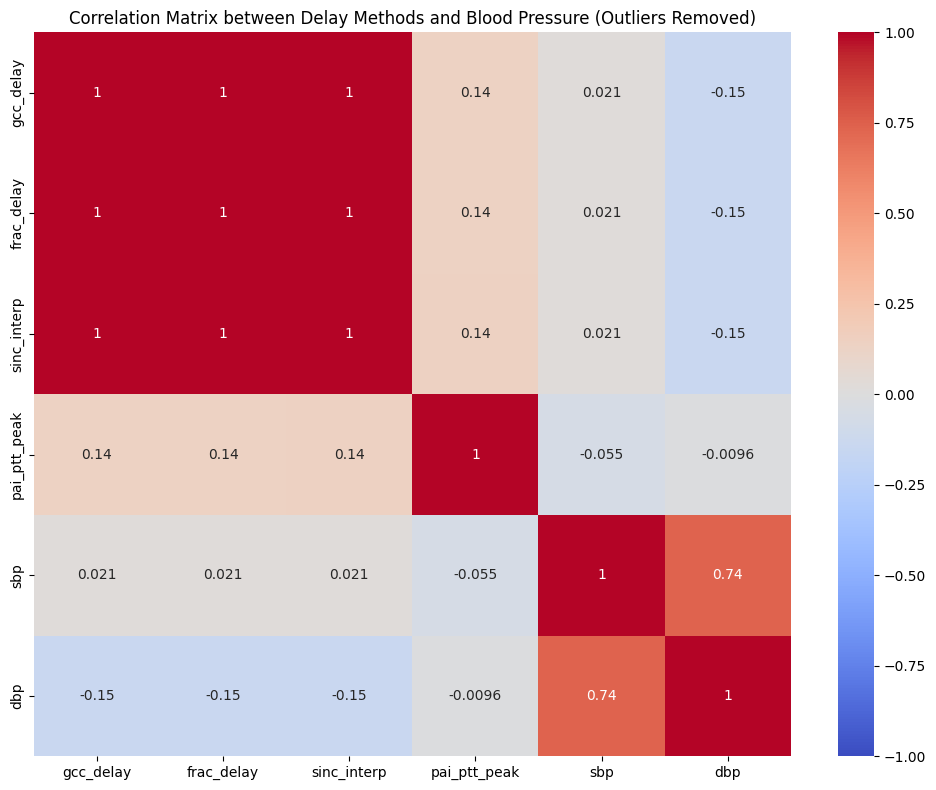

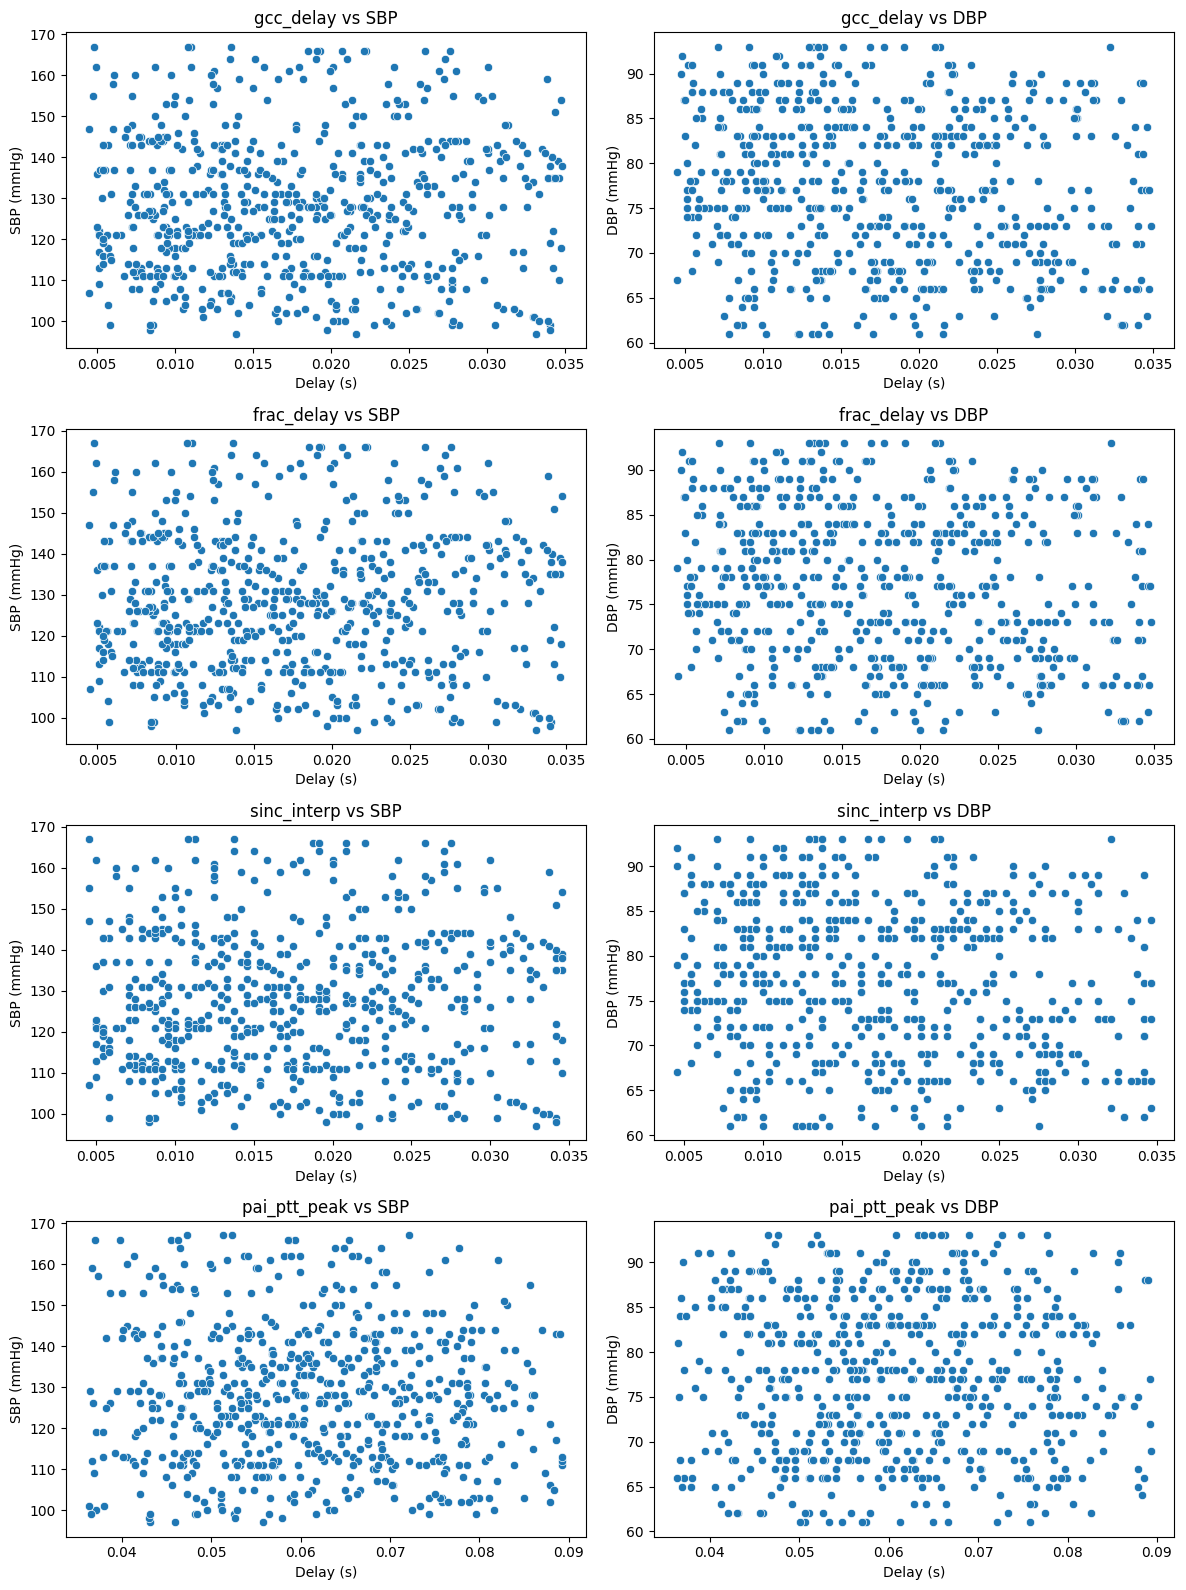


Correlation with SBP (outliers removed):
gcc_delay: 0.021
frac_delay: 0.021
sinc_interp: 0.021
pai_ptt_peak: -0.055

Correlation with DBP (outliers removed):
gcc_delay: -0.147
frac_delay: -0.147
sinc_interp: -0.148
pai_ptt_peak: -0.010

Original samples: 1367
Samples after outlier removal: 639
Samples removed: 728


In [141]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to remove outliers using IQR method
def remove_outliers(df, columns):
    df_clean = df.copy()
    for col in columns:
        # Q1 = df_clean[col].quantile(0.25)
        # Q3 = df_clean[col].quantile(0.75)
        # IQR = Q3 - Q1
        # lower_bound = Q1 - 1.5 * IQR
        # upper_bound = Q3 + 1.5 * IQR
        lower_bound = df_clean[col].quantile(0.05)
        upper_bound = df_clean[col].quantile(0.95)
        print(f"{col}: {lower_bound} - {upper_bound}")
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    return df_clean

# Remove outliers from both delay methods and BP measurements
delay_methods = ['gcc_delay', 'frac_delay', 'sinc_interp', 'pai_ptt_peak']
bp_measures = ['sbp', 'dbp']
corr_cols = delay_methods + bp_measures
delay_df_clean = remove_outliers(delay_df, corr_cols)

# Create correlation matrix with cleaned data
correlation_matrix = delay_df_clean[corr_cols].corr()

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Matrix between Delay Methods and Blood Pressure (Outliers Removed)')
plt.tight_layout()
plt.show()

# Scatter plots for each method vs BP with cleaned data
fig, axes = plt.subplots(len(delay_methods), 2, figsize=(12, 4*len(delay_methods)))
for i, method in enumerate(delay_methods):
    # Plot vs SBP
    sns.scatterplot(data=delay_df_clean, x=method, y='sbp', ax=axes[i,0])
    axes[i,0].set_title(f'{method} vs SBP')
    axes[i,0].set_xlabel('Delay (s)')
    axes[i,0].set_ylabel('SBP (mmHg)')
    
    # Plot vs DBP
    sns.scatterplot(data=delay_df_clean, x=method, y='dbp', ax=axes[i,1])
    axes[i,1].set_title(f'{method} vs DBP')
    axes[i,1].set_xlabel('Delay (s)')
    axes[i,1].set_ylabel('DBP (mmHg)')

plt.tight_layout()
plt.show()

# Print correlation statistics for cleaned data
print("\nCorrelation with SBP (outliers removed):")
for method in delay_methods:
    corr = delay_df_clean[method].corr(delay_df_clean['sbp'])
    print(f"{method}: {corr:.3f}")

print("\nCorrelation with DBP (outliers removed):")
for method in delay_methods:
    corr = delay_df_clean[method].corr(delay_df_clean['dbp'])
    print(f"{method}: {corr:.3f}")

# Print the number of samples removed
print(f"\nOriginal samples: {len(delay_df)}")
print(f"Samples after outlier removal: {len(delay_df_clean)}")
print(f"Samples removed: {len(delay_df) - len(delay_df_clean)}")


Cleaning data for gcc_delay:
gcc_delay: 0.000 - 0.044
sbp: 97.0 - 169.0
dbp: 60.0 - 97.0
Samples after cleaning: 882 (removed 485)

Cleaning data for frac_delay:
frac_delay: -0.030 - 0.058
sbp: 98.0 - 167.0
dbp: 60.0 - 97.0
Samples after cleaning: 947 (removed 420)

Cleaning data for sinc_interp:
sinc_interp: -0.021 - 0.055
sbp: 98.0 - 169.0
dbp: 60.0 - 97.0
Samples after cleaning: 950 (removed 417)

Cleaning data for pai_ptt_peak:
pai_ptt_peak: 0.036 - 0.093
sbp: 98.0 - 169.0
dbp: 60.0 - 97.0
Samples after cleaning: 947 (removed 420)


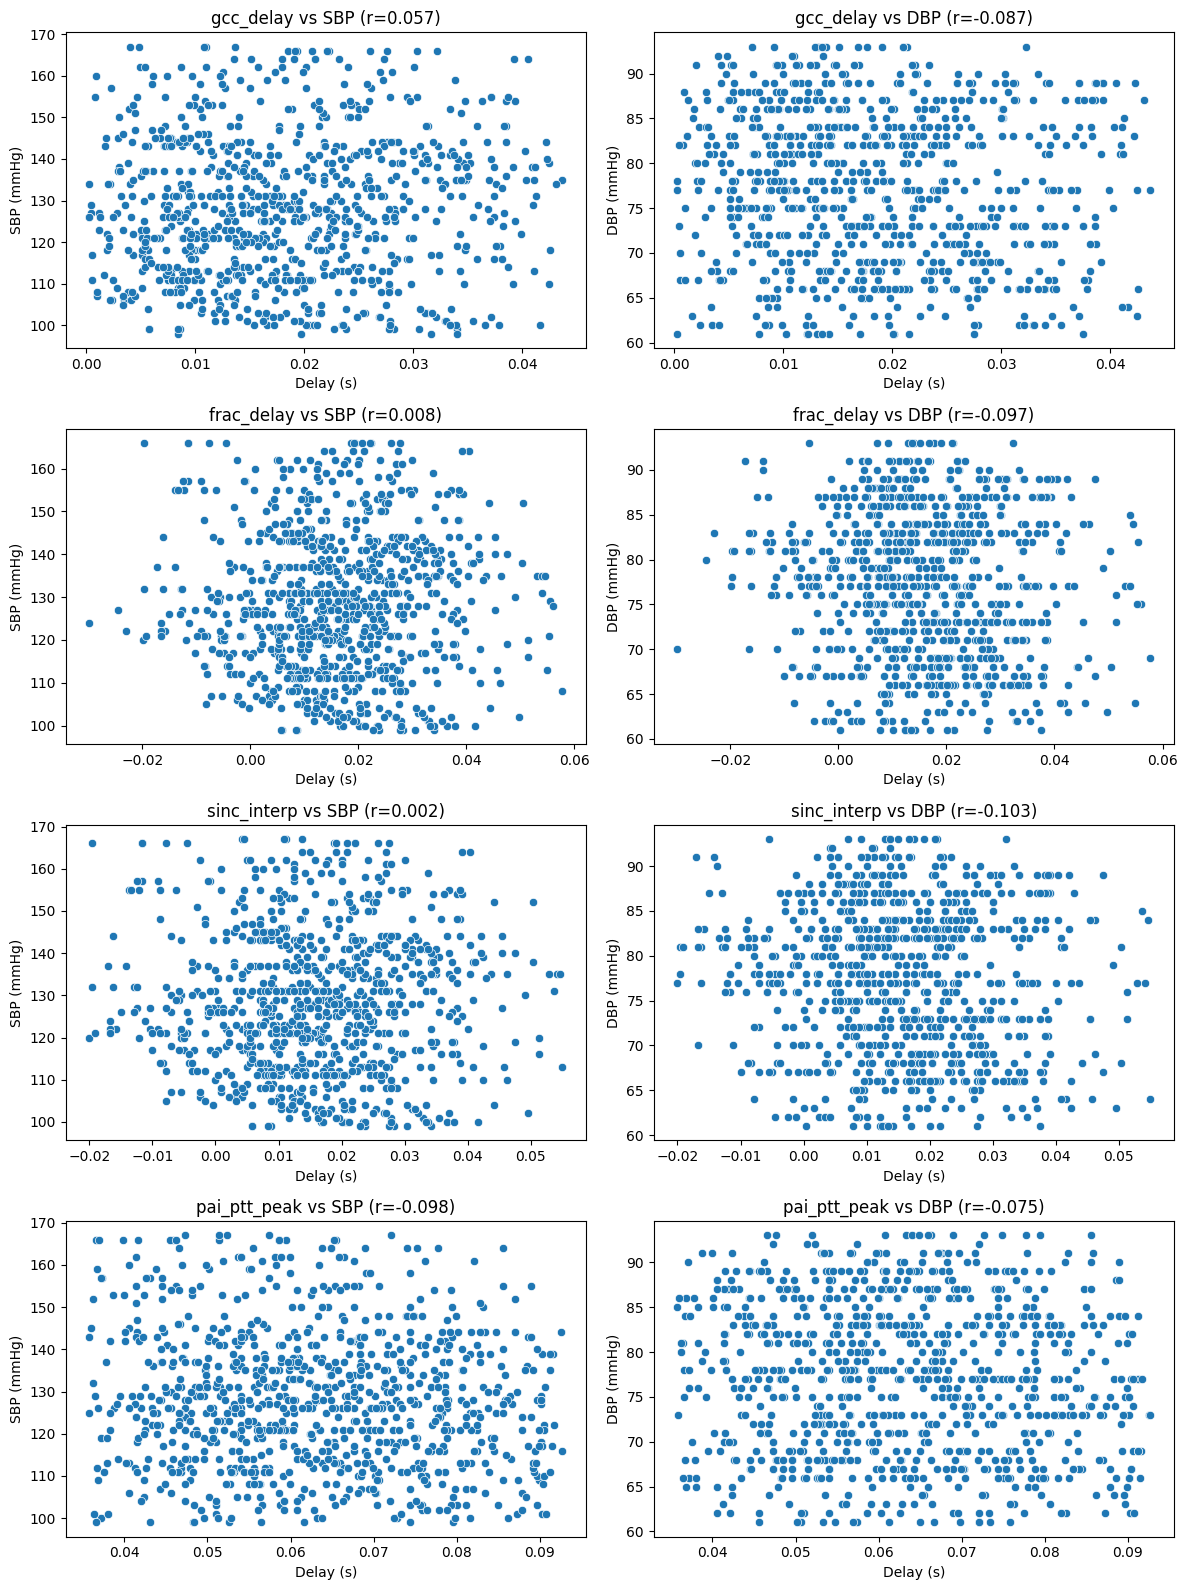


Correlation Summary:
Method      |    SBP    |    DBP
-----------------------------------
gcc_delay  |     0.057 |    -0.087
frac_delay |     0.008 |    -0.097
sinc_interp|     0.002 |    -0.103
pai_ptt_peak|    -0.098 |    -0.075


In [142]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Function to remove outliers for a single method
def remove_outliers_single(df, method_col, bp_cols):
    df_clean = df.copy()
    # Remove outliers from method column
    lower_bound = df_clean[method_col].quantile(0.05)
    upper_bound = df_clean[method_col].quantile(0.95)
    print(f"{method_col}: {lower_bound:.3f} - {upper_bound:.3f}")
    df_clean = df_clean[(df_clean[method_col] > lower_bound) & (df_clean[method_col] < upper_bound)]
    
    # Remove outliers from BP columns
    for col in bp_cols:
        lower_bound = df_clean[col].quantile(0.05)
        upper_bound = df_clean[col].quantile(0.95)
        print(f"{col}: {lower_bound:.1f} - {upper_bound:.1f}")
        df_clean = df_clean[(df_clean[col] > lower_bound) & (df_clean[col] < upper_bound)]
    return df_clean

# Plot correlations for each method independently
delay_methods = ['gcc_delay', 'frac_delay', 'sinc_interp', 'pai_ptt_peak']
bp_measures = ['sbp', 'dbp']

fig, axes = plt.subplots(len(delay_methods), 2, figsize=(12, 4*len(delay_methods)))
correlations = {}

for i, method in enumerate(delay_methods):
    # Clean data for this specific method
    print(f"\nCleaning data for {method}:")
    clean_data = remove_outliers_single(delay_df, method, bp_measures)
    correlations[method] = {}
    
    # Plot vs SBP
    sns.scatterplot(data=clean_data, x=method, y='sbp', ax=axes[i,0])
    corr_sbp = clean_data[method].corr(clean_data['sbp'])
    axes[i,0].set_title(f'{method} vs SBP (r={corr_sbp:.3f})')
    axes[i,0].set_xlabel('Delay (s)')
    axes[i,0].set_ylabel('SBP (mmHg)')
    correlations[method]['sbp'] = corr_sbp
    
    # Plot vs DBP
    sns.scatterplot(data=clean_data, x=method, y='dbp', ax=axes[i,1])
    corr_dbp = clean_data[method].corr(clean_data['dbp'])
    axes[i,1].set_title(f'{method} vs DBP (r={corr_dbp:.3f})')
    axes[i,1].set_xlabel('Delay (s)')
    axes[i,1].set_ylabel('DBP (mmHg)')
    correlations[method]['dbp'] = corr_dbp
    
    print(f"Samples after cleaning: {len(clean_data)} (removed {len(delay_df) - len(clean_data)})")

plt.tight_layout()
plt.show()

# Print summary of correlations
print("\nCorrelation Summary:")
print("Method      |    SBP    |    DBP")
print("-" * 35)
for method in delay_methods:
    print(f"{method:11}|  {correlations[method]['sbp']:8.3f} |  {correlations[method]['dbp']:8.3f}")